In [1]:
### Imports ###

# General data manipulation and plotting packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u

# Exoplanet data packages
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Standard Python libraries
import os # Operating system interfaces
from urllib.request import urlretrieve # Query with links
import re # Regular expressions

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# Matplotlib settings
fontweight = 300
plt.rcParams['font.weight'] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22


### Retrieve planetary information ###

# Identify the planet and query the database 
planet_name = 'MASCARA-1 b'
NEA_result = NasaExoplanetArchive.query_object(planet_name)
TIC_id = NEA_result['tic_id'][0] # extracts the TESS Input Catalog ID number associated with the planet

# Extract ephemeris information
ephemeris_ind = 0 # NEA reports numerous ephermis solutions for this planet, just use first (zeroth)

# Extract orbital period (P), mid-transit time(t_0), and transit duration(t_dur)
P = 2.14877381 * u.day
t_0 = 1833.488151 * u.day
t_dur = 4.226 * u.hour
print('Period: ', P)
print('Mid-transit time: ', t_0)
print('Transit duration: ', t_dur)

# Use lightkurve package to retrieve TESS photometry for this target
TESS_result = lk.search_lightcurve(TIC_id, mission='TESS', author='SPOC', exptime=120)

# Show sectors of data available for target
TESS_result

Period:  2.14877381 d
Mid-transit time:  1833.488151 d
Transit duration:  4.226 h


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 55,2022,SPOC,120,354619337,0.0


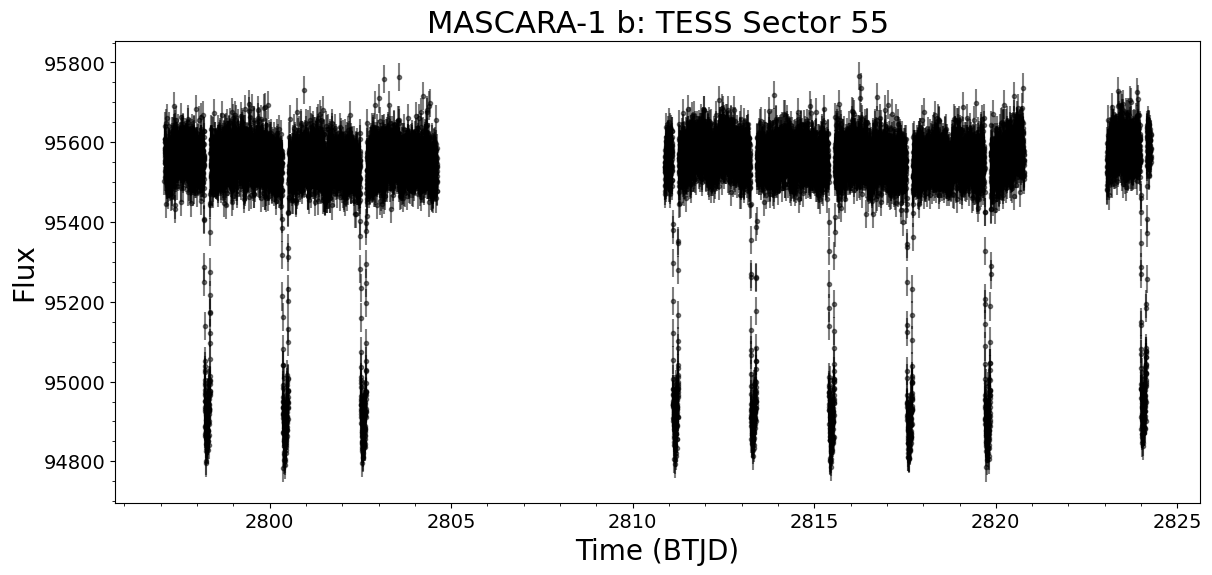

In [2]:
### Retrieve lightcurve ###

# Select sector
sector_ind = 0
sector = TESS_result.mission[sector_ind]

# Get lightcurve
lc = TESS_result[sector_ind].download() # by default ignores cadences with severe quality issues

# Change the ND masked arrays to numpy arrays
lc.time = np.array(lc.time)
lc.flux = np.array(lc.flux)
lc.flux_err = np.array(lc.flux_err)

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name + ': ' + sector)
plt.show()

Bad data quality flags present in Sector TESS Sector 55
Flag: 0 , Reason: 
Flag: 16 , Reason: Argabrightening
Flag: 4096 , Reason: Straylight2
Flag: 16384 , Reason: Bad Calibration Exclude
Flag: 16400 , Reason: Argabrightening Bad Calibration Exclude
Flag: 32768 , Reason: Insufficient Targets for Error Correction Exclude


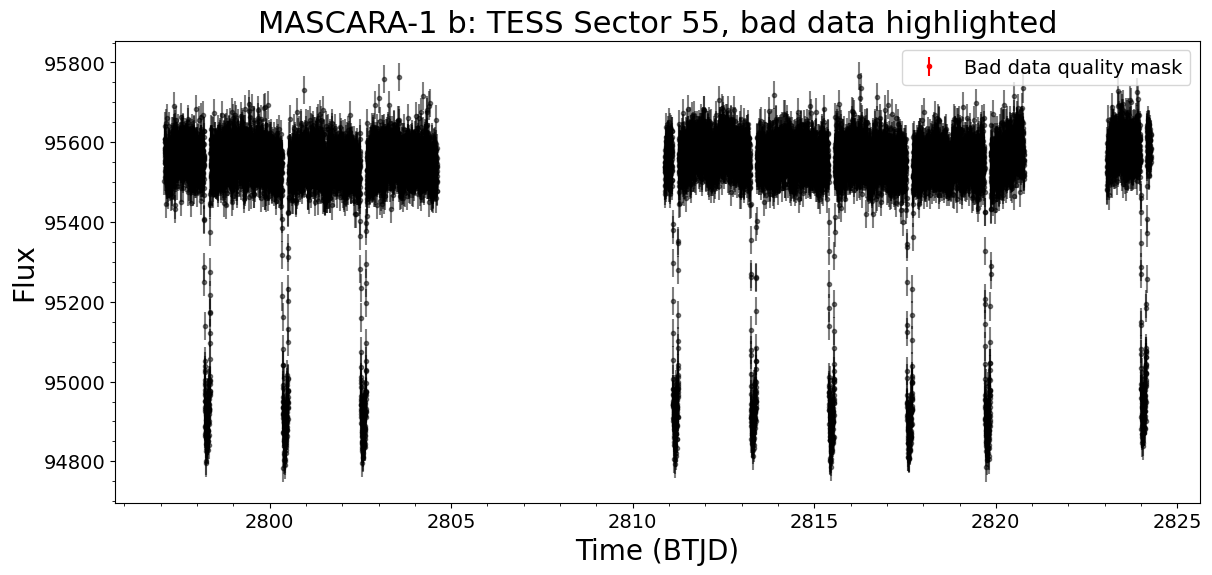

In [3]:
### Bad data ###

# Bad data quality flags present in our data
print('Bad data quality flags present in Sector ' + str(sector))
for flag in np.unique(lc.quality):
    print('Flag:', flag, ', Reason:', ' '.join(lk.TessQualityFlags.decode(flag)))
    
# Mask of bad data quality points
mask_bad = lc.quality != 0 # bad data points have non-zero quality flags

# Plot lightcurve with bad data highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_bad], lc.flux.value[mask_bad], lc.flux_err.value[mask_bad], fmt='.', color='r',
            label = 'Bad data quality mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name + ': ' + sector + ', bad data highlighted')
plt.legend(fontsize=14)
plt.show()

Text(0.5, 1.0, 'MASCARA-1 b: TESS Sector 55, transits/secondary eclipses higlighted')

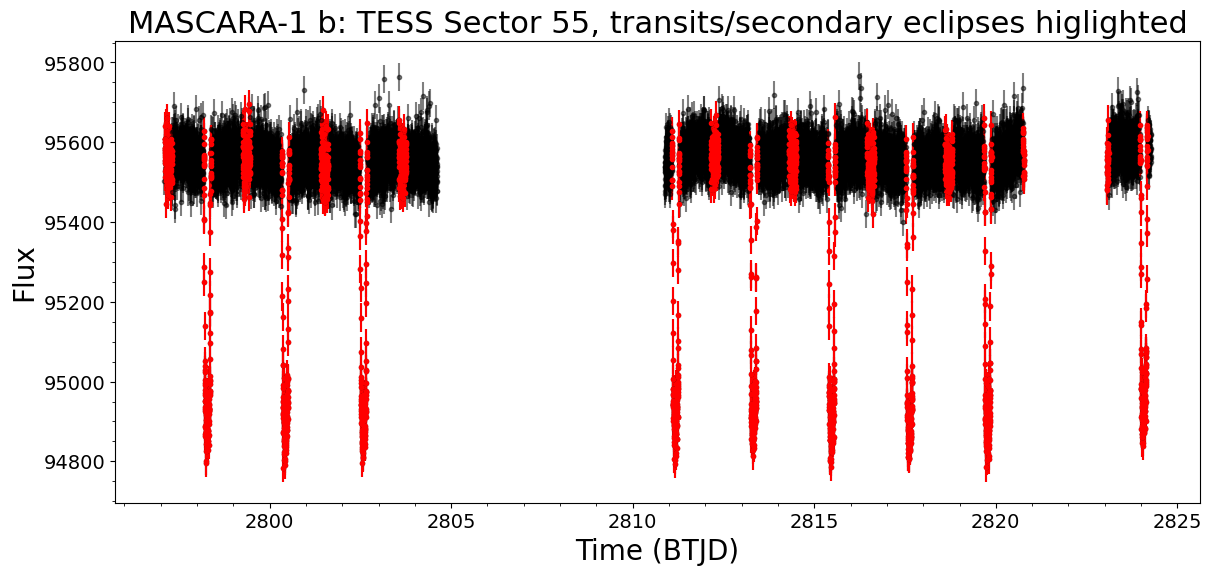

In [4]:
### Remove secondary eclipses and transits ###

# Create mask and include a bit beyond nominal transit duration for good measure in case ephemeris is not precise
mask_transit = TPC.create_transit_mask(lc, P, t_0, 1.2*t_dur)

# Plot light curve with transits and secondary eclipses highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_transit], lc.flux.value[mask_transit], lc.flux_err.value[mask_transit], fmt='.',
            color='r', label='Transit/secondary eclipse mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name + ': ' + sector + ', transits/secondary eclipses higlighted')

C:\Users\jenna\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jenna\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


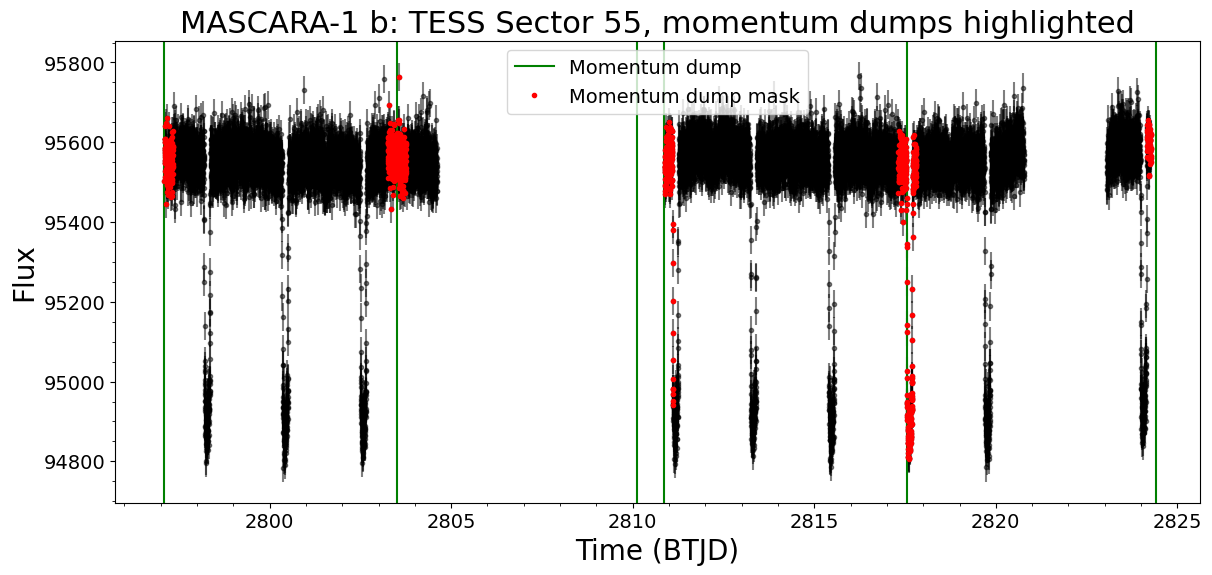

In [5]:
### Momentum dumps ###

# Download the table of momentum dumps
url = 'https://tess.mit.edu/public/files/Table_of_momentum_dumps.csv'
filename = 'Table_of_momentum_dumps.csv'
fullfilename = os.path.join(os.getcwd(), filename) # Path at which to save the file
urlretrieve(url, fullfilename); # Retrieves and saves the file locally

# Read in momentum dumps
momentum_dumps = np.genfromtxt(filename, delimiter=",", comments='#') # read table
momentum_dumps_times = momentum_dumps[:, 1] # 4th column gives the cadences of the dumps
momentum_dumps_times = momentum_dumps_times[(momentum_dumps_times>min(lc.time.value)-0.25) & 
                                            (momentum_dumps_times<max(lc.time.value)+0.25)] # Select only dumps in sector
# Clean up momentum dump data
momentum_dumps_times_copy = np.copy(momentum_dumps_times)
momentum_dumps_times = np.array([])
for time in momentum_dumps_times_copy:
    similar = np.where(abs(momentum_dumps_times_copy - time) <= 0.25)
    momentum_dumps_times = np.hstack([momentum_dumps_times, np.mean(momentum_dumps_times_copy[similar])])
    momentum_dumps_times_copy = np.delete(momentum_dumps_times_copy, similar)
momentum_dumps_times = np.unique(momentum_dumps_times[~np.isnan(momentum_dumps_times)])

# Construct mask identifying data points taken within 0.25 days of a momentum dump
mask_dumps = np.array([False]*len(lc.time.value))
for dump_time in momentum_dumps_times:
    mask_dumps += abs(lc.time.value-dump_time) <= 0.25

# Plot lightcurve with observations taken near momentum dumps highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_dumps], lc.flux.value[mask_dumps], fmt='.', color='r', label='Momentum dump mask')
for i, dump_time in enumerate(momentum_dumps_times):
    if i == 0:
        plt.axvline(dump_time, color='g', label='Momentum dump')
    else:
        plt.axvline(dump_time, color='g')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', momentum dumps highlighted')
plt.legend(fontsize=14)
plt.show()

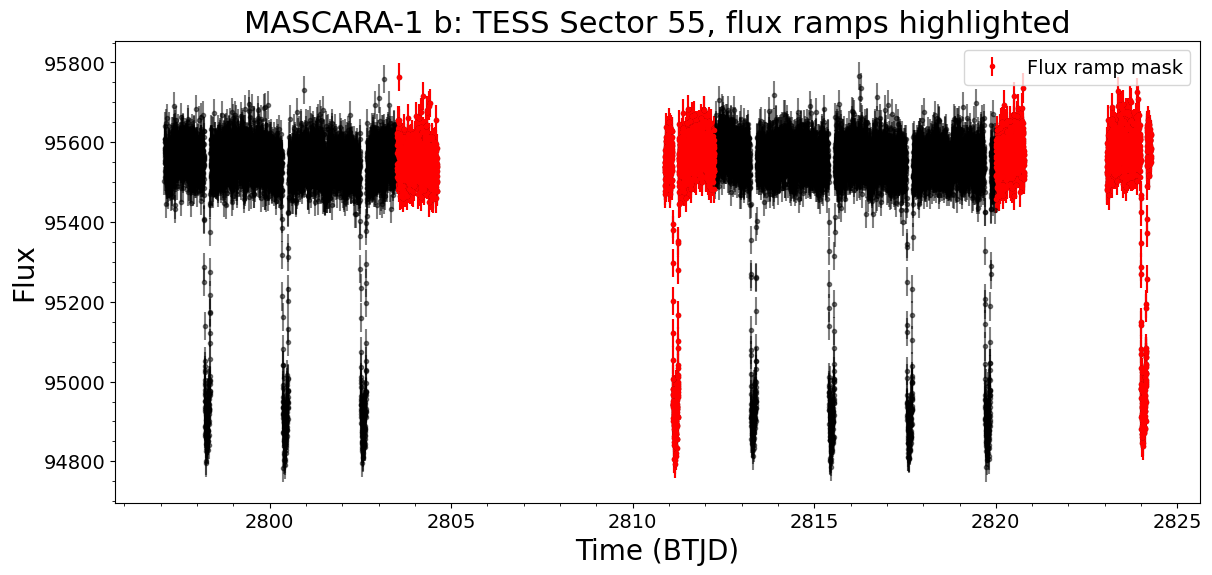

In [6]:
### Flux ramps ###

# Create an array with pairs of times that correspond to the start and end times of a flux ramp

# Sector 0 ##
flux_ramps = np.array([[2803.5, 2805],
                       [2810, 2812.25],
                       [2820, 2821],
                       [2822, 2825]])

# Go through each pair of flux ramp start/end times and mask out the observations that fall in between
mask_ramps = np.array([False]*len(lc.time.value))
for flux_ramp in flux_ramps:
    ind_ramp = np.argwhere((lc.time.value > flux_ramp[0]) & (lc.time.value < flux_ramp[1]))
    mask_ramps[ind_ramp] = True
    
# Plot light curve with flux ramps highlighted
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_ramps], lc.flux.value[mask_ramps], lc.flux_err.value[mask_ramps], fmt='.',
            color='r', label='Flux ramp mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', flux ramps highlighted')
plt.legend(fontsize=14)
plt.show()

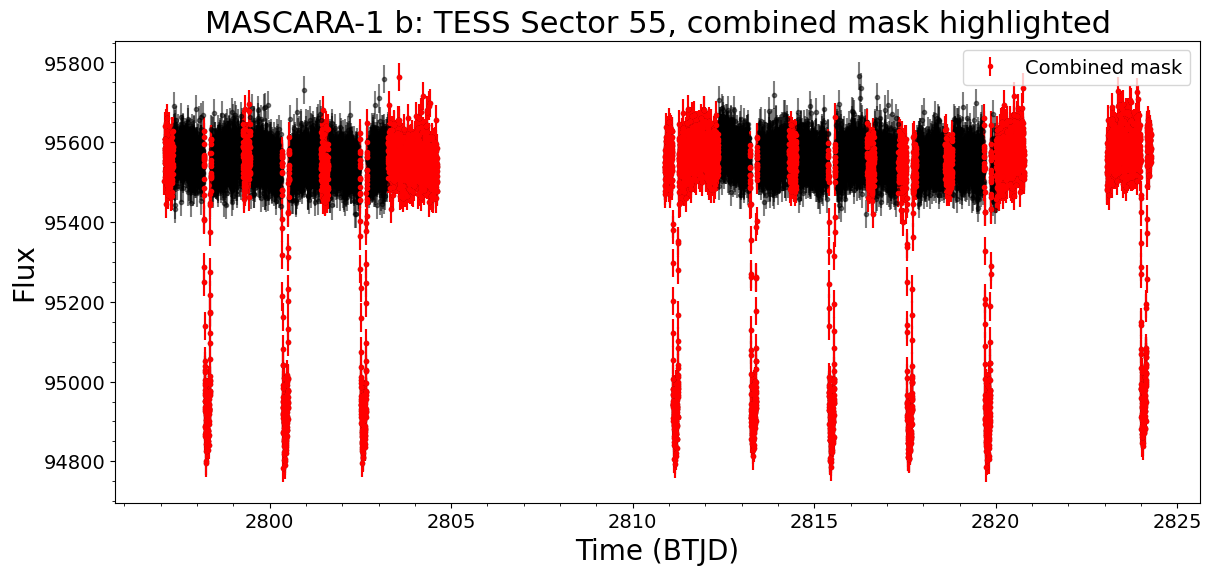

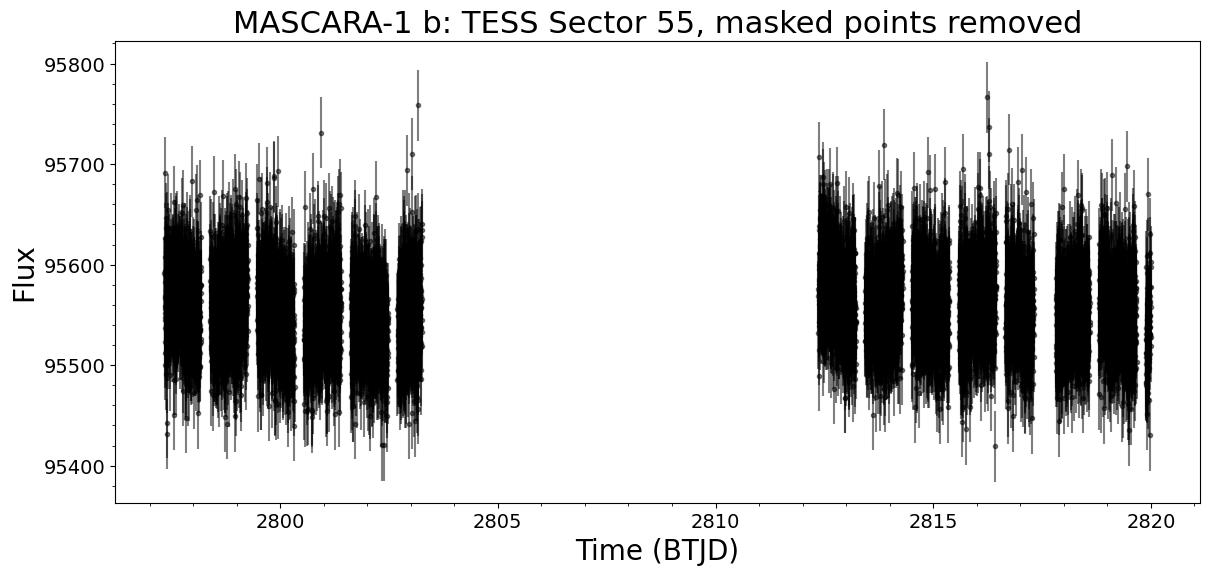

In [7]:
### Combined mask ###

# Create a mask of all the masks
mask = mask_bad + mask_transit + mask_dumps + mask_ramps

# Plot light curve with combined mask
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask], lc.flux.value[mask], lc.flux_err.value[mask], fmt='.',
            color='r', label='Combined mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', combined mask highlighted')
plt.legend(fontsize=14)
plt.show()

# Remove the masked points
lc = lc[~mask]

# Plot data with masked points removed
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', masked points removed')
plt.show()

Segment:  1 , optimized normalization polynomial degree:  1 SSE:  5286911.008892983
Segment:  4 , optimized normalization polynomial degree:  1 SSE:  4409471.771648779
Segment:  5 , optimized normalization polynomial degree:  1 SSE:  1857426.0288525587


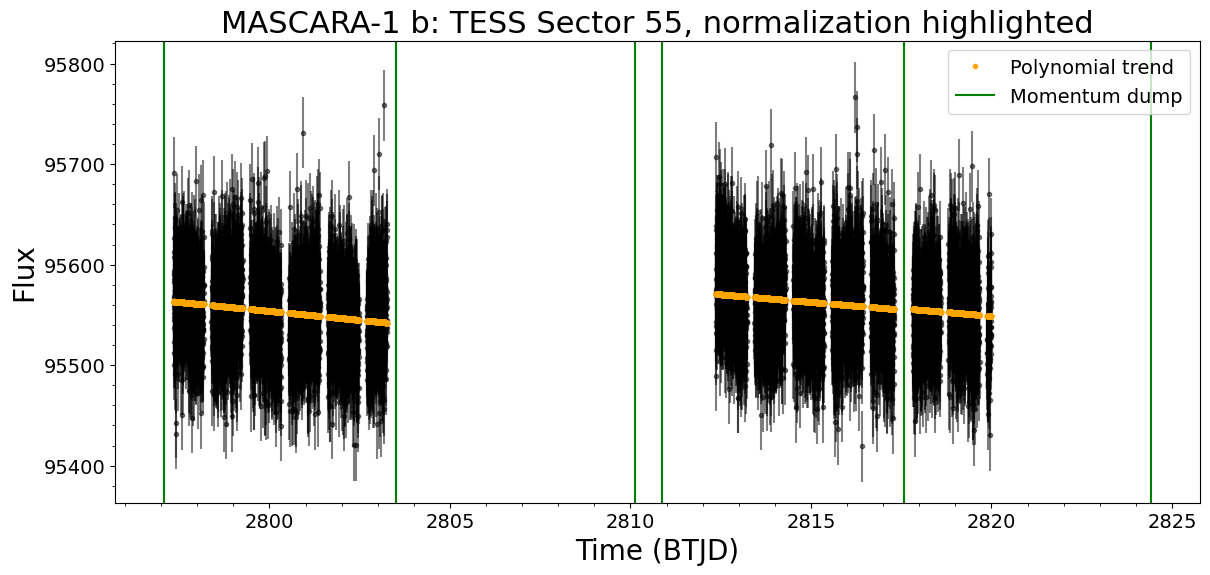

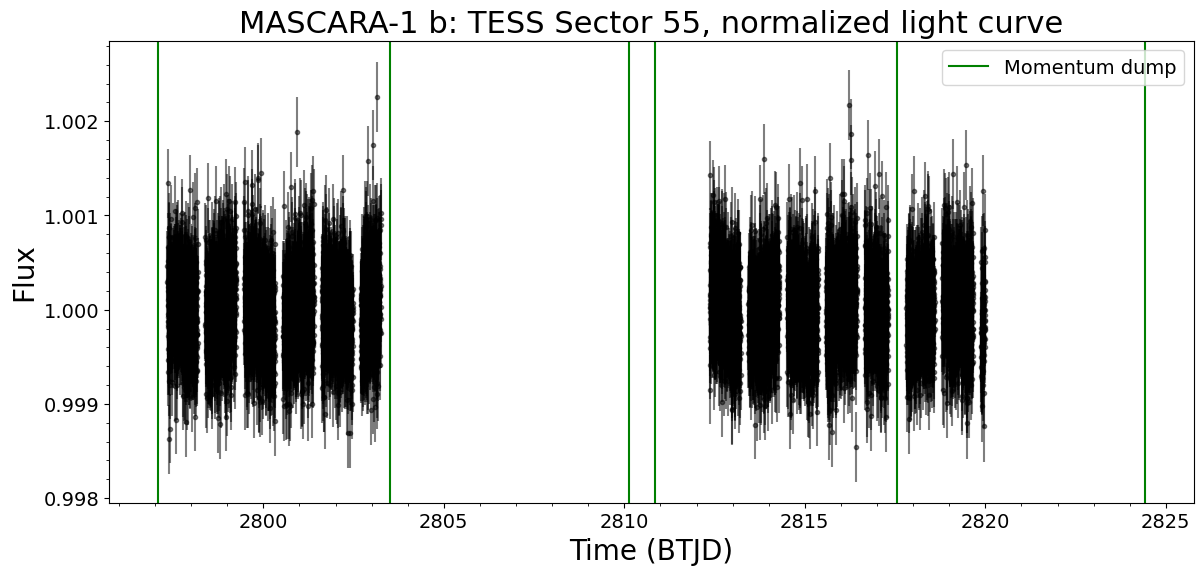

In [8]:
### Normalization ###

normalization = np.array([])
begin = min(lc.time.value)

for i, dump in enumerate(momentum_dumps_times):
    SSE_best, normalization_best, deg_best = np.inf, None, None
    
    ## Loop first segment to second to last segment ##
    
    # Select data within a given momentum dump segment
    segment = (lc.time.value >= begin) * (lc.time.value < dump)
    if np.sum(segment) == 0:
        continue 
    time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]
    
    # Check segment length and prevent steep slopes on short segments
    TPC.segment_analysis(time_segment, flux_segment, P)
    
    # Test best polynomial fit
    for deg in range(2): # checks for polynomials of order up to 3, excluding 3
        p = np.polyfit(time_segment, flux_segment, deg)
        f = np.poly1d(p)
        normalization_deg = f(time_segment)
        SSE = np.sum((flux_segment - normalization_deg)**2)
        if SSE < SSE_best:
            SSE_best = SSE
            normalization_best = normalization_deg
            deg_best = deg
    normalization = np.hstack([normalization, normalization_best])
    
    print('Segment: ', i, ', optimized normalization polynomial degree: ', deg_best, 'SSE: ', SSE_best)
    
    begin = np.copy(dump)
    if i == len(momentum_dumps_times)-1:
        SSE_best, normalization_best, deg_best = np.inf, None, None
        
        ## Repeat for final segment ##
        
        # Select data within a given momentum dump segment
        segment = (lc.time.value > begin)
        if np.sum(segment) == 0:
            break
        time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]
        
        # Check segment length and prevent steep slopes on short segments
        TPC.segment_analysis(time_segment, flux_segment, P)
        
        # Test best polynomial fit
        for deg in range(2): # checks for polynomials of order up to 2, excluding 2
            p = np.polyfit(time_segment, flux_segment, deg)
            f = np.poly1d(p)
            normalization_deg = f(time_segment)
            SSE = np.sum((flux_segment - normalization_deg)**2)
            if SSE < SSE_best:
                SSE_best = SSE
                normalization_best = normalization_deg
                deg_best = deg
        normalization = np.hstack([normalization, normalization_best])
        
        print('Segment: ', i+1, ', optimized normalization polynomial degree: ', deg_best, 'SSE: ', SSE_best)
        
# Plot lightcurve with observations with normalization continuum
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=0)
plt.plot(lc.time.value, normalization, '.', color='orange', label='Polynomial trend')
for i, dump_time in enumerate(momentum_dumps_times):
    if i == 0:
        plt.axvline(dump_time, color='g', label='Momentum dump')
    else:
        plt.axvline(dump_time, color='g')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', normalization highlighted')
plt.legend(fontsize=14)
plt.show()

# Normalize
lc = lc/normalization

# Plot normalized light curve
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=0)
for i, dump_time in enumerate(momentum_dumps_times):
    if i == 0:
        plt.axvline(dump_time, color='g', label='Momentum dump')
    else:
        plt.axvline(dump_time, color='g')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name + ': ' + sector + ', normalized light curve')
plt.legend(fontsize=14)
plt.show()

C:\Users\jenna\AppData\Local\Temp\ipykernel_4708\1738854106.py:5: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_fold.phase_arr = np.array(lc_fold.phase)


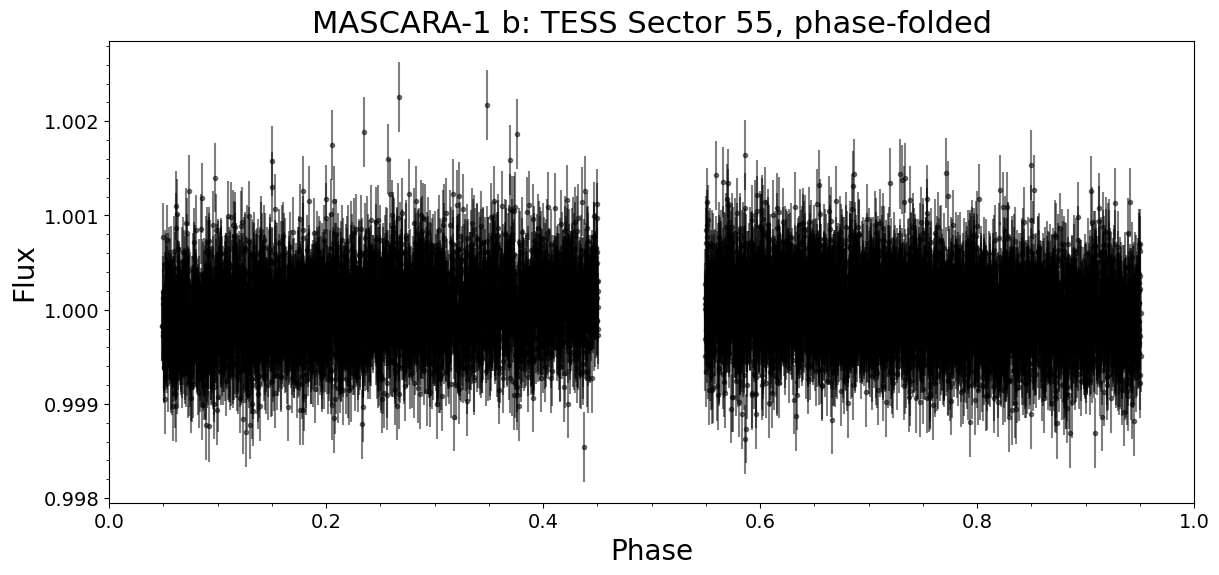

In [9]:
### Phase-folding lightcurve ###

# Phase-fold
lc_fold = lc.fold(P, epoch_time = t_0, normalize_phase=True) # need normalize_phase=True to definephase from -0.5 to 0.5
lc_fold.phase_arr = np.array(lc_fold.phase)
lc_fold.phase_arr[lc_fold.phase_arr < 0] = lc_fold.phase[lc_fold.phase_arr < 0] + 1 # wrap phases to go from 0 to 1

# Plot phase-folded lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc_fold.phase_arr, lc_fold.flux.value, lc_fold.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0,1)
plt.title(planet_name + ': ' + sector + ', phase-folded')
plt.show()

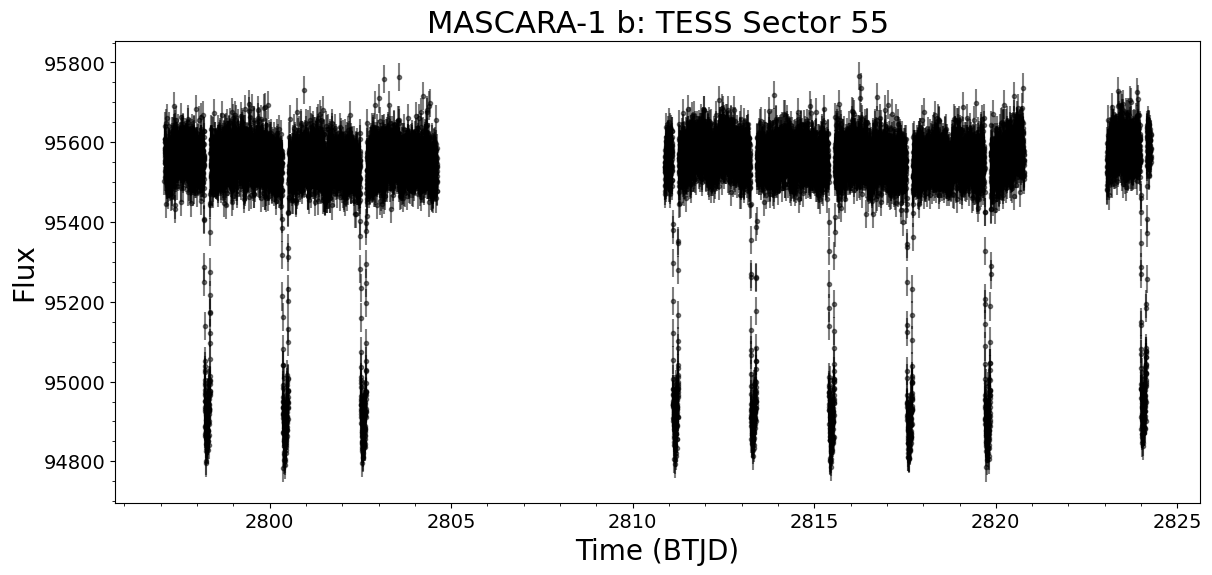

C:\Users\jenna\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jenna\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


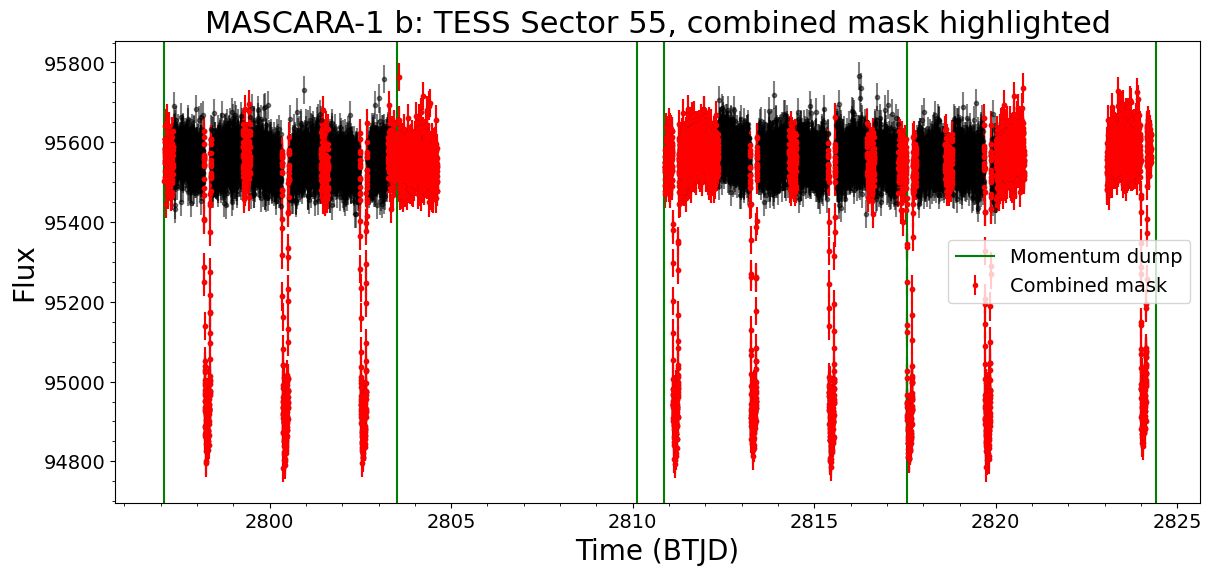

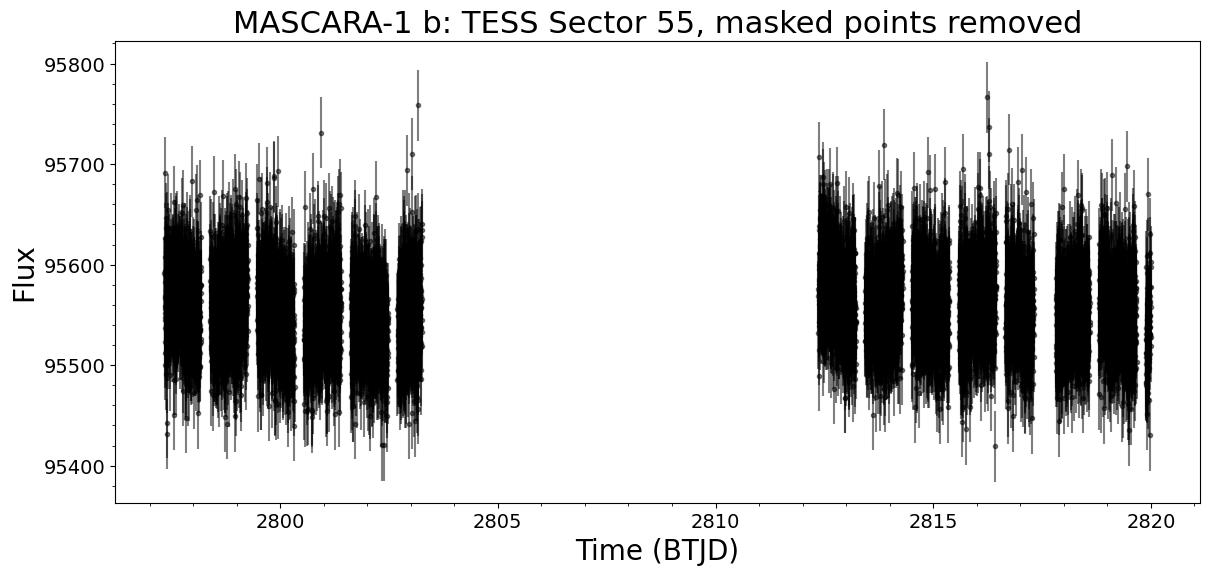

Segment:  1 , optimized normalization polynomial degree:  1 SSE:  5286911.008892983
Segment:  4 , optimized normalization polynomial degree:  1 SSE:  4409471.771648779
Segment:  5 , optimized normalization polynomial degree:  1 SSE:  1857426.0288525587


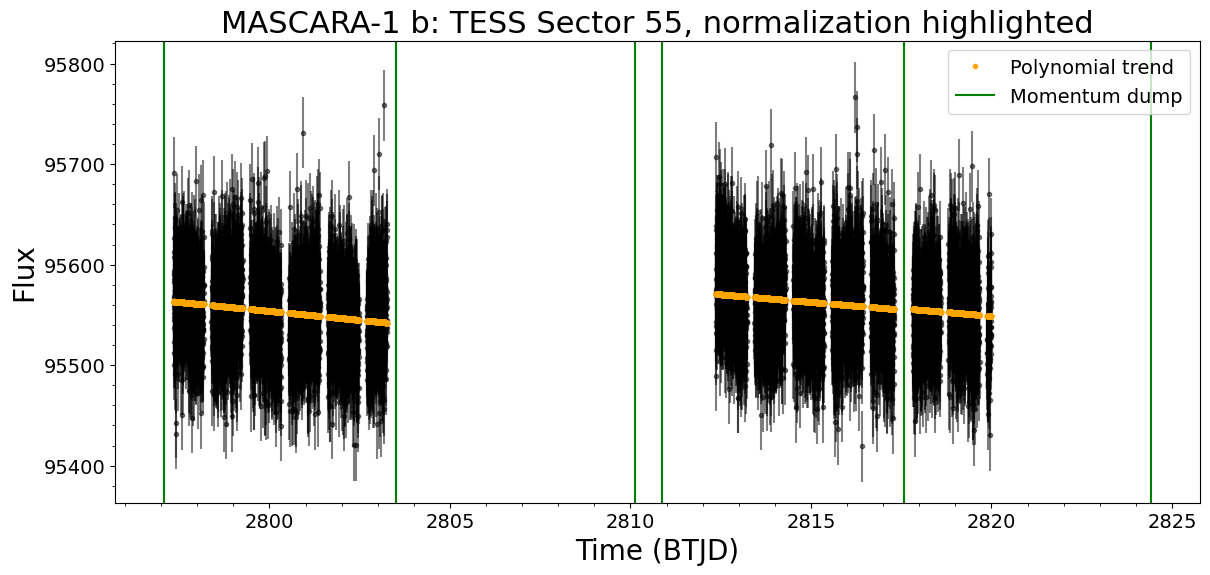

C:\Users\jenna\AppData\Local\Temp\ipykernel_4708\647273536.py:192: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_fold.phase_arr = np.array(lc_fold.phase)


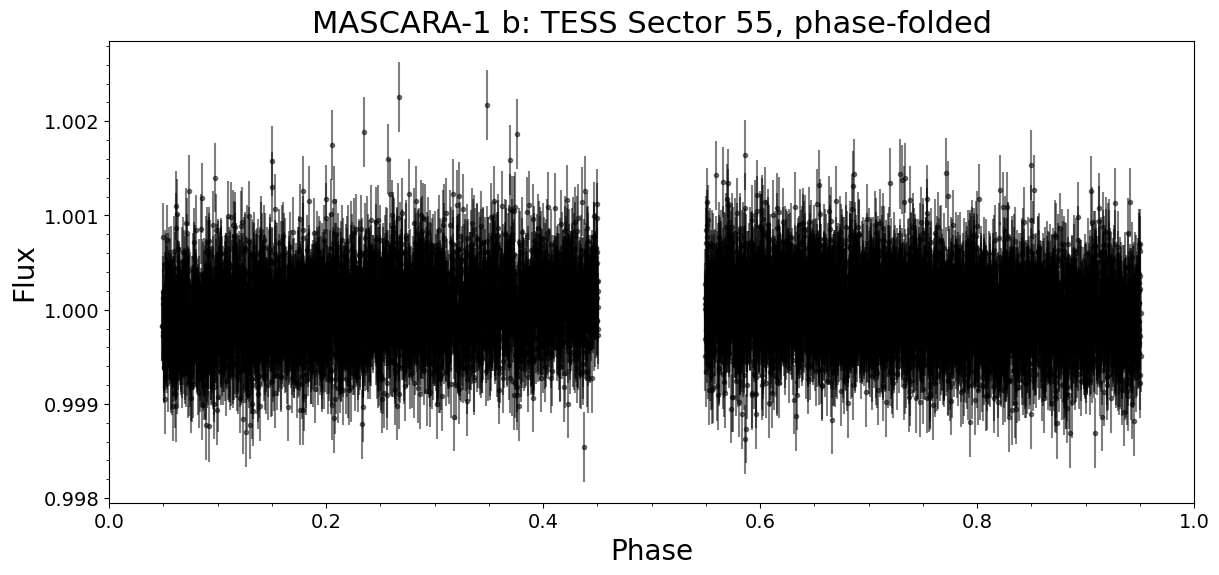

In [10]:
### ALL SECTORS ###

# Download the table of momentum dumps
url = 'https://tess.mit.edu/public/files/Table_of_momentum_dumps.csv'
filename = 'Table_of_momentum_dumps.csv'
fullfilename = os.path.join(os.getcwd(), filename) # Path at which to save the file
urlretrieve(url, fullfilename); # Retrieves and saves the file locally

# Read in momentum dumps
momentum_dumps = np.genfromtxt(filename, delimiter=',', comments='#') # Read table

# Array of flux ramps
flux_ramps = np.array([[2803.5, 2805],
                       [2810, 2812.25],
                       [2820, 2821],
                       [2822, 2825]])
                       
# Initialize a dictionary to save the data 
df_dict = {
    'sector': np.array([]),
    'time': np.array([]),
    'flux': np.array([]),
    'flux_err': np.array([])
}

# Loop through all sectors
for sector_ind in range(len(TESS_result)):
    
    # Select the sector
    sector = TESS_result.mission[sector_ind]
    sector_num = int(re.findall(r'\d+', sector)[0])
    
    # Get lightcurve
    lc = TESS_result[sector_ind].download() # By default ignores cadences with severe quality issues
    
    # Change the ND masked arrays to nump arrays
    lc.time = np.array(lc.time)
    lc.flux = np.array(lc.flux)
    lc.flux_err = np.array(lc.flux_err)
    
    # Plot the lightcurve for visual inspection, partially to identify unexpected phase ramps
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name + ': ' + sector)
    plt.show()
    
    # Mask of bad data quality points
    mask_bad = lc.quality != 0 # Bad data have non-zero quality flags
    
    # Mask of transits and secondary eclipses
    mask_transit = TPC.create_transit_mask(lc, P, t_0, 1.2*t_dur)
    
    # Mask of momentum dumps
    momentum_dumps_times = momentum_dumps[:, 1] # 4th column gives the cadences of the dumps
    momentum_dumps_times = momentum_dumps_times[(momentum_dumps_times > (min(lc.time.value) - 0.25)) & 
                                                (momentum_dumps_times < (max(lc.time.value) + 0.25))] # Select only dumps in sector
    
    # Clean up momentum dump data
    momentum_dumps_times_copy = np.copy(momentum_dumps_times)
    momentum_dumps_times = np.array([])
    
    for time in momentum_dumps_times_copy:
        similar = np.where(abs(momentum_dumps_times_copy - time) <= 0.25)
        momentum_dumps_times = np.hstack([momentum_dumps_times, np.mean(momentum_dumps_times_copy[similar])])
        momentum_dumps_times_copy = np.delete(momentum_dumps_times_copy, similar)
    momentum_dumps_times = np.unique(momentum_dumps_times[~np.isnan(momentum_dumps_times)])
    
    mask_dumps = np.array([False]*len(lc.time.value))
    
    for dump_time in momentum_dumps_times:
        mask_dumps += abs(lc.time.value - dump_time) <= 0.25
        
    # Go through each pair of flux ramp start/end times and mask out the observations that fall in between
    mask_ramps = np.array([False]*len(lc.time.value))
    
    for flux_ramp in flux_ramps:
        ind_ramp = np.argwhere((lc.time.value > flux_ramp[0]) & (lc.time.value < flux_ramp[1]))
        mask_ramps[ind_ramp] = True
        
    # Combined mask
    mask = mask_bad + mask_transit + mask_dumps + mask_ramps
    
    # PLot data with combined mask highlighted in red
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.errorbar(lc.time.value[mask], lc.flux.value[mask], lc.flux_err.value[mask], fmt='.',
                color='r', label='Combined mask')
    for i, dump_time in enumerate(momentum_dumps_times):
        if i == 0:
            plt.axvline(dump_time, color='g', label='Momentum dump')
        else:
            plt.axvline(dump_time, color='g')
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name + ': ' + sector + ', combined mask highlighted')
    plt.legend(fontsize=14)
    plt.show()
    
    # Removed masked points
    lc = lc[~mask]
    
    # Plot data with masked points removed
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name + ': ' + sector + ', masked points removed')
    plt.show()
    
    # Normalize/long-term detrending across momentum dumps
    normalization = np.array([])
    begin = min(lc.time.value)
    for i, dump in enumerate(momentum_dumps_times):
        SSE_best, normalization_best, deg_best = np.inf, None, None
        
        ## Loop first segment to second to last segment ##
    
        # Select data within a given momentum dump segment
        segment = (lc.time.value >= begin) * (lc.time.value < dump)
        if np.sum(segment) == 0:
            continue 
        time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]

        # Check segment length and prevent steep slopes on short segments
        TPC.segment_analysis(time_segment, flux_segment, P)

        # Test best polynomial fit
        for deg in range(2): # checks for polynomials of order up to 3, excluding 3
            p = np.polyfit(time_segment, flux_segment, deg)
            f = np.poly1d(p)
            normalization_deg = f(time_segment)
            SSE = np.sum((flux_segment - normalization_deg)**2)
            if SSE < SSE_best:
                SSE_best = SSE
                normalization_best = normalization_deg
                deg_best = deg
        normalization = np.hstack([normalization, normalization_best])

        print('Segment: ', i, ', optimized normalization polynomial degree: ', deg_best, 'SSE: ', SSE_best)

        begin = np.copy(dump)
        if i == len(momentum_dumps_times)-1:
            SSE_best, normalization_best, deg_best = np.inf, None, None

            ## Repeat for final segment ##

            # Select data within a given momentum dump segment
            segment = (lc.time.value > begin)
            if np.sum(segment) == 0:
                break
            time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]

            # Check segment length and prevent steep slopes on short segments
            TPC.segment_analysis(time_segment, flux_segment, P)

            # Test best polynomial fit
            for deg in range(2): # checks for polynomials of order up to 2, excluding 2
                p = np.polyfit(time_segment, flux_segment, deg)
                f = np.poly1d(p)
                normalization_deg = f(time_segment)
                SSE = np.sum((flux_segment - normalization_deg)**2)
                if SSE < SSE_best:
                    SSE_best = SSE
                    normalization_best = normalization_deg
                    deg_best = deg
            normalization = np.hstack([normalization, normalization_best])

            print('Segment: ', i+1, ', optimized normalization polynomial degree: ', deg_best, 'SSE: ', SSE_best)

    # Plot lightcurve with observations with normalization continuum
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=0)
    plt.plot(lc.time.value, normalization, '.', color='orange', label='Polynomial trend')
    for i, dump_time in enumerate(momentum_dumps_times):
        if i == 0:
            plt.axvline(dump_time, color='g', label='Momentum dump')
        else:
            plt.axvline(dump_time, color='g')
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name+': '+sector+', normalization highlighted')
    plt.legend(fontsize=14)
    plt.show()

    # Normalize lightcurve
    lc = lc/normalization

    # Phase-fold
    lc_fold = lc.fold(P, epoch_time=t_0, normalize_phase=True) # need normalize_phase=True to define phase from -0.5 to 0.5
    lc_fold.phase_arr = np.array(lc_fold.phase)
    lc_fold.phase_arr[lc_fold.phase_arr<0] = lc_fold.phase[lc_fold.phase_arr<0] + 1. # wrap phases to go from 0 to 1

    # Plot phase-folded lightcurve
    plt.figure(figsize=(14,6))
    plt.errorbar(lc_fold.phase_arr, lc_fold.flux.value, lc_fold.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.xlim(0, 1)
    plt.title(planet_name+': '+sector+', phase-folded')
    plt.show()

    df_dict['sector'] = np.int64(np.hstack([df_dict['sector'], sector_num*np.ones_like(lc.time.value)]))
    df_dict['time'] = np.hstack([df_dict['time'], lc.time.value])
    df_dict['flux'] = np.hstack([df_dict['flux'], lc.flux.value])
    df_dict['flux_err'] = np.hstack([df_dict['flux_err'], lc.flux_err.value])
    
    # Save data
    data_dir = os.getcwd() + '/lightcurves/'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    df = pd.DataFrame(df_dict)
    df.to_csv('lightcurves/' + planet_name.replace(" ", "") + '.csv', index=False);    